## **TITANIC SURVIVAL PREDICTION**

# Importing necessary libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


In [45]:
#read dataset
df= pd.read_csv("/content/titanic_dataset_tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploring dataset

In [16]:
df.shape #dimensions

(418, 12)

In [17]:
df.dtypes #datatypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [18]:
#checking null values
100*df.isna().mean()

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

In [19]:
survive_count = df['Survived'].value_counts()
survive_rate = 100*survive_count/df.shape[0]
survive_data = pd.concat([survive_count,survive_rate],axis=1).reset_index()
survive_data.columns = ['survive','Count','Percentage']

survive_data

,survive,Count,Percentage
0,0,266,63.636364
1,1,152,36.363636


Text(0.5, 1.0, 'percentage survival of the titanic Passengers')

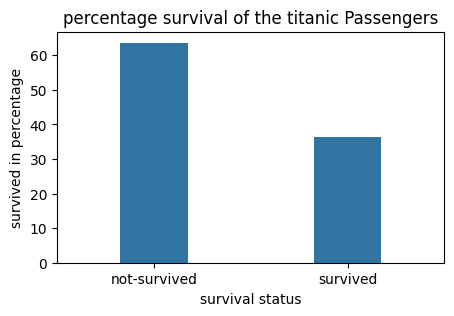

In [20]:
#plot the survival percentage
plt.figure(figsize=(5, 3))
sns.barplot(survive_data, x=['not-survived', 'survived'],y='Percentage',width=0.35)
plt.xlabel("survival status")
plt.ylabel("survived in percentage")
plt.title("percentage survival of the titanic Passengers")

In [21]:
# survival rate according to grps
def survival_grp(df, colname):
    plt.figure(figsize=(5, 3))
    survival_Pclass = df[[colname, 'Survived']].value_counts().reset_index(name='count')
    sns.barplot(data=survival_Pclass, x=colname, y='count', hue='Survived')
    plt.ylabel("number of survived")
    plt.title(f"survival based on {colname}")

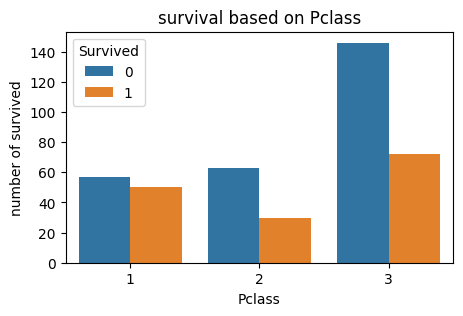

In [22]:
#survival in Pclass
survival_grp(df,'Pclass')

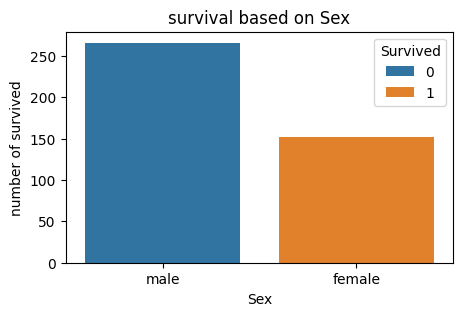

In [23]:
#survival based on gender
survival_grp(df,'Sex')

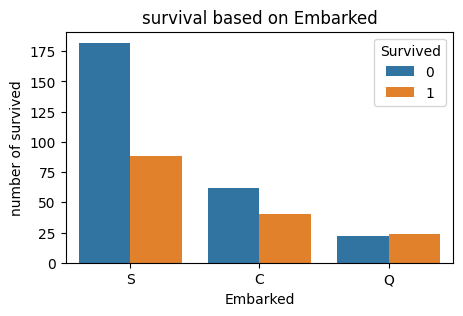

In [25]:
survival_grp(df,'Embarked')

In [26]:
#distribution of variables based on survival
def var_surv(df, colname):
  plt.figure(figsize=(5, 3))
  sns.kdeplot(df, x=colname, hue='Survived')
  plt.title(f'{colname} distribution based on survival')


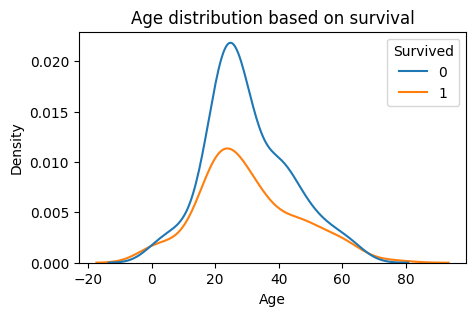

In [27]:
var_surv(df,'Age')

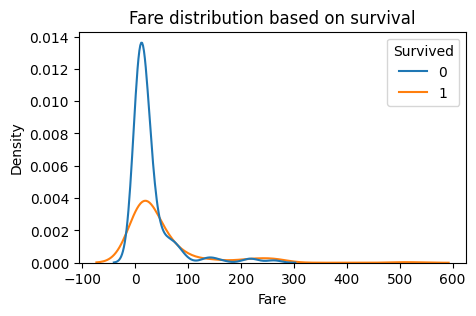

In [28]:
var_surv(df,'Fare')

In [29]:
#visulaize count data
def count_surv(df, colname):
  plt.figure(figsize=(5,3))
  df1=df.groupby(['SibSp','Survived',]).count()['PassengerId'].reset_index()
  sns.barplot(df1, x='SibSp',y='PassengerId',hue='Survived')
  plt.title(f'{colname} based on survival')
  plt.xlabel(f'{colname}')
  plt.ylabel('count')

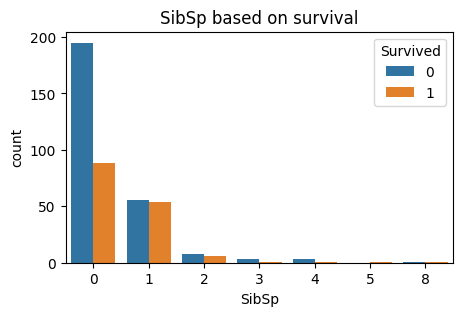

In [30]:
count_surv(df,'SibSp')

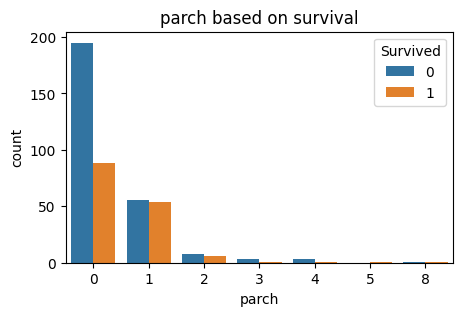

In [31]:
count_surv(df, 'parch')

Text(0, 0.5, 'values')

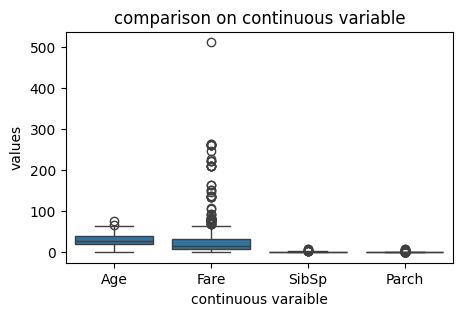

In [32]:
cont =pd.melt(df,value_vars=['Age','Fare','SibSp','Parch'])
plt.figure(figsize=(5,3))
sns.boxplot(cont,x='variable',y='value')
plt.title('comparison on continuous variable')
plt.xlabel('continuous varaible')
plt.ylabel('values')

# data preparation


In [33]:
df = df.drop(['PassengerId','Name','Cabin'],axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,34.5,0,0,330911,7.8292,Q
1,1,3,female,47.0,1,0,363272,7.0000,S
2,0,2,male,62.0,0,0,240276,9.6875,Q
3,0,3,male,27.0,0,0,315154,8.6625,S
4,1,3,female,22.0,1,1,3101298,12.2875,S


In [34]:
df= df.dropna(subset='Fare')#deleting 'Fare' column

In [35]:
df.loc[df['Age'].isnull(), 'Age'] = df['Age'].median()#fill age by median

In [46]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [37]:
#balancing
df_surv = df[df['Survived']==1]
df_not_surv = df[df['Survived']==0]
df_surv_resample = df_surv.sample(n=df_not_surv.shape[0],replace=True, random_state=101)
df_balanced = pd.concat([df_not_surv,df_surv_resample]).sample(frac=1,random_state=26)
df_balanced

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
195,0,3,male,33.0,0,0,347465,7.8542,S
332,0,3,male,27.0,0,0,2684,7.2250,C
219,0,3,male,27.0,0,0,32302,8.0500,S
118,0,1,male,36.0,0,0,13050,75.2417,C
382,1,3,female,27.0,0,0,364498,14.5000,S
...,...,...,...,...,...,...,...,...,...
259,0,3,male,21.0,0,0,345501,7.7750,S
128,0,2,male,42.0,0,0,211535,13.0000,S
166,0,1,male,48.0,0,0,PC 17591,50.4958,C
309,1,3,female,45.0,1,0,350026,14.1083,S


In [38]:
df_balanced['Survived'].value_counts()

0    265
1    265
Name: Survived, dtype: int64

In [39]:
x=df_balanced.drop(['Survived'],axis=1)
y=df_balanced['Survived']

In [40]:
#train ans test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1055)
print(f'''
x_train:{x_train.shape}
x_test:{x_test.shape}
y_train:{y_train.shape}
y_test:{y_test.shape}''')



x_train:(424, 8)
x_test:(106, 8)
y_train:(424,)
y_test:(106,)


# model building

In [52]:
cont_cols = ['Age', 'Fare']
disc_cols = ['SibSp', 'Parch']
cat_cols = ['Pclass','Sex', 'Embarked']
cont_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())])
disc_transformer = Pipeline(steps =[
    ('scaler',MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot',OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', cont_transformer, cont_cols),
        ('disc',disc_transformer,disc_cols),
        ('cat',categorical_transformer,cat_cols)
    ]
)
model= Pipeline(steps=[('preprocessor',preprocessor),
                       ('classifier',LogisticRegression())])
model.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('disc',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression())])

In [53]:
y_pred = model.predict(x_test)
y_pred #prediction

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [55]:
#classification report
cl_report = classification_report(y_test, y_pred)
print(cl_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        48

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



Text(33.22222222222222, 0.5, 'Predicted Value')

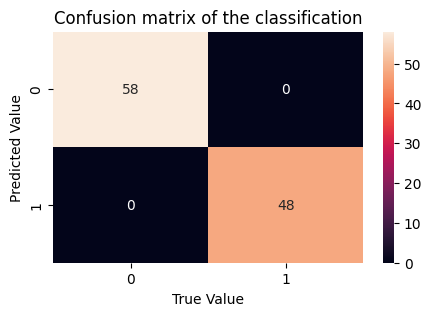

In [57]:
c_mat = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(c_mat,annot=True)
plt.title('Confusion matrix of the classification')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')


In [58]:
#saving
with open('./model_logistic.pkl','wb') as fp:
  pickle.dump(model,fp)

 **prediction of the passenger survivals of the titanic using the LR model**